In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
#print('Using CAMB installed at '+ os.path.realpath(os.path.join(os.getcwd(),'..')))

from scipy import integrate
from numpy import loadtxt
import copy
import math
import pandas as pd

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams.update({'font.size': 11})

#### Load redshift bins and galaxy density n(z) for spectroscopic and photometric samples
(The photometric $n(z)$ is not normalized)

https://arxiv.org/pdf/1308.4164.pdf

In [2]:
f=open('n_z.txt',"r")
lines=f.readlines()
zspec_tmp=[];nspec_tmp=[]
for x in lines:
    zspec_tmp.append(float(x.split(None)[0]))
    nspec_tmp.append(float(x.split(None)[1]))
f.close()

f=open('redshifts_phot.txt',"r")
lines=f.readlines()
z_phot=[]; z_min=[]; z_max=[]; nphot_tmp=[]
for x in lines:
    z_min.append(float(x.split(None)[0]))
    z_phot.append(float(x.split(None)[1]))
    z_max.append(float(x.split(None)[2]))
    nphot_tmp.append(float(x.split(None)[3]))
f.close()

zspec_tmp=np.array(zspec_tmp)
nspec_tmp=np.array(nspec_tmp)*((0.675)**3.)
z_phot=np.array(z_phot)
nphot_tmp=np.array(nphot_tmp)

### Set fiducial cosmology

In [3]:
fid_params={'h':[0.675], 'Omb':[0.048], 'Omc':[0.268], 'ns':[0.965], 'As':[2e-09], 'w':[-1.0]}
print 'Fiducial Parameters:', fid_params

#List of fiducial parameters:
params_f=[p[0] for p in fid_params.itervalues()]

n_pts=200
f_sky=0.048

Fiducial Parameters: {'Omc': [0.268], 'Omb': [0.048], 'h': [0.675], 'As': [2e-09], 'w': [-1.0], 'ns': [0.965]}


### Specify parameters to vary and step size

In [4]:
#step_dict={'Omc':[0.003], 'w':[0.03]}
step_dict={'Omb':[0.002], 'Omc':[0.003], 'ns':[0.01], 'As':[5e-11], 'w':[0.03]}

print 'Parameters to vary and step size:',step_dict

Parameters to vary and step size: {'Omc': [0.003], 'Omb': [0.002], 'As': [5e-11], 'ns': [0.01], 'w': [0.03]}


In [5]:
def list_params(Step_dict, Fid_params):
    step_keys=[key for key in Step_dict.iterkeys()]
    keys=[p for p in Fid_params.iterkeys()]

    Params=copy.deepcopy(Fid_params)

    for i in keys:
        if i in step_keys:
            Params[i].append(Fid_params[i][0]+Step_dict[i][0])
            Params[i].append(Fid_params[i][0]-Step_dict[i][0])
        Params[i].sort()
    return [Params[i] for i in keys], step_keys

params_list, step_label=list_params(step_dict, fid_params)
print 'Cosmological parameters that will be used:', params_list

Cosmological parameters that will be used: [[0.265, 0.268, 0.271], [0.046, 0.048, 0.05], [0.675], [1.95e-09, 2e-09, 2.05e-09], [-1.03, -1.0, -0.97], [0.955, 0.965, 0.975]]


### Calculate matter power spectrum for various cosmologies

In [6]:
def Power_spectrum(param, Z_bin, K_max):
    Omc, Omb, h, A_s, w, n_s = param
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100.*h, ombh2=Omb*(h**2), omch2=Omc*(h**2.), omk=0)
    pars.set_dark_energy(w)
    pars.InitPower.set_params(As= A_s, ns=n_s)
    pars.set_matter_power(redshifts=Z_bin, kmax=2.0)

    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-3, maxkh=K_max, npoints = n_pts)
    t = results.get_matter_transfer_data()
    
    qt=t.transfer_data[0, :, 0]
    transf=[]
    for i in range(len(Z_bin)):
        transf_interp=interp1d(qt, t.transfer_data[6, :, i])
        transf.append(transf_interp(kh))
    
    if param==params_f:
        res_fid = camb.get_results(pars)
        t_fid = res_fid.get_matter_transfer_data()

        qt_fid=t_fid.transfer_data[0, :, 0]
        transf_fid=[]
        for i in range(len(Z_bin)):
            interp_fid=interp1d(qt_fid, t_fid.transfer_data[6, :, i])
            transf_fid.append(interp_fid(kh))        
        return kh, pk, res_fid, np.array(transf_fid)[::-1,:]

    return kh, pk, np.array(transf)[::-1,:]

def calculate_PS(Params_list, Params_f, n_params, print_steps, Z_bin, K_max):
    PS=np.zeros((2*n_params,len(Z_bin), n_pts))
    transf=np.zeros((2*n_params,len(Z_bin), n_pts))
    Omega_m=[]; W=[]

    l=0; vary=[]
    for i in range(len(Params_list)):
        for j in range(len(Params_list[i])):
            if len(Params_list[i])>1:
                par=list(Params_f)
                par[i]=Params_list[i][j]
                if par!=Params_f:
                    vary.append(Params_list[i][j])
                    k, PS[l], transf[l] =Power_spectrum(par, Z_bin, K_max)
                    l+=1
                    if print_steps:
                        print 'Parameters: (%s,%s)'%(i, j), par
                    Omega_m.append(par[0]+par[1])
                    W.append(par[4])
    return k, PS, transf, vary, Omega_m, W

k, PS, Transf, vary, omg_m, w=calculate_PS(params_list, params_f, len(step_dict), True, zspec_tmp, 0.2)

Note: redshifts have been re-sorted (earliest first)
Parameters: (0,0) [0.265, 0.048, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (0,2) [0.271, 0.048, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (1,0) [0.268, 0.046, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (1,2) [0.268, 0.05, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (3,0) [0.268, 0.048, 0.675, 1.95e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)


Parameters: (3,2) [0.268, 0.048, 0.675, 2.05e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)


Parameters: (4,0) [0.268, 0.048, 0.675, 2e-09, -1.03, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (4,2) [0.268, 0.048, 0.675, 2e-09, -0.97, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (5,0) [0.268, 0.048, 0.675, 2e-09, -1.0, 0.955]
Note: redshifts have been re-sorted (earliest first)
Parameters: (5,2) [0.268, 0.048, 0.675, 2e-09, -1.0, 0.975]


### Fiducial Case

In [7]:
k, PS_fid, res_fid, Transf_fid=Power_spectrum(params_f, zspec_tmp, 0.2)
H_bar = np.array([res_fid.h_of_z(i) for i in zspec_tmp])
r_z=np.array([res_fid.comoving_radial_distance(i) for i in zspec_tmp])
c=299792.
print 'H(z)=', H_bar*c

Note: redshifts have been re-sorted (earliest first)
H(z)= [ 128.49325278  132.25296141  136.08036789  139.9738019   143.9316816
  147.952509    152.03486533  156.17740646  160.37885855  164.63801379
  168.95372635  173.32490859  177.75052737  182.22960066  186.76119435
  191.34441915  195.97842785  200.66241263  205.39560265  215.00668597
  224.80616634  234.78899179  244.95051634  255.28645361  265.79283658
  276.46598263  287.30246323]


### Normalizing the photometric $n(z)$

The photometric $n(z)$ must be normalized such that the total sample contains 45 galaxies/arcmin$^2$ = $45 \cdot \left( \frac{10800}{\pi} \right)^2$ galaxies/sr, i.e.

\begin{equation}
\int dz\ \frac{r^2(z)}{H(z)}\ \left(\frac{dN}{dV}\right) = 45\ \text{gal/arcmin}^2
\end{equation}

In [8]:
def integ_z(z,dndz):
    return (((res_fid.comoving_radial_distance(z))**2.)/(res_fid.h_of_z(z)))*dndz

nphot_tmp2=[]
for i in range(len(z_phot)):
    integ=integrate.quad(integ_z, z_min[i], z_max[i], args=(nphot_tmp[i]))
    nphot_tmp2.append(integ[0])
norm =sum(nphot_tmp2)/(45.*((10800./np.pi)**2.))
n_phot=np.array(nphot_tmp)/(norm)

In [9]:
ngal_spec=[]
for i in range(len(zspec_tmp)-1):
    ngal_spec.append(4.*np.pi*f_sky*(integrate.quad(integ_z, zspec_tmp[i], zspec_tmp[i+1], args=(nspec_tmp[i]/((params_f[2])**3.)))[0]))
    
print 'Total number of photometric galaxies = ', sum(4.*np.pi*f_sky*(np.array(nphot_tmp2)/norm))/(10**6.), '10^6'
print 'Total number of spectroscopic galaxies = ', sum(ngal_spec)/(10**6.), '10^6'

Total number of photometric galaxies =  320.783026675 10^6
Total number of spectroscopic galaxies =  24.8711150276 10^6


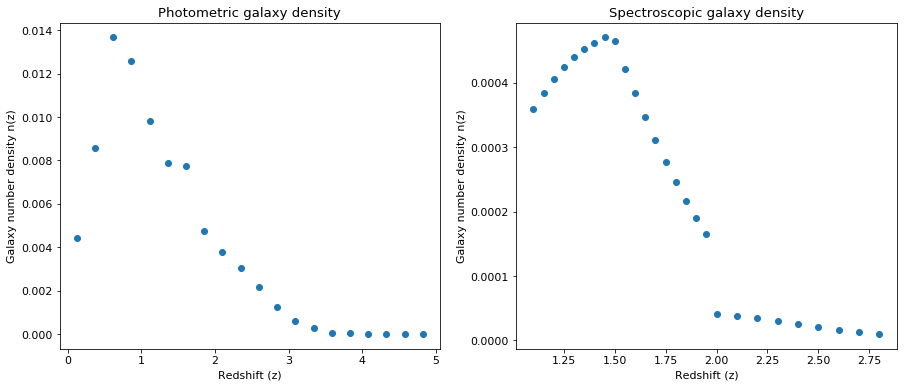

In [10]:
plt.rcParams['figure.figsize'] = (15, 6)

plt.subplot(121)
plt.plot(z_phot, n_phot,'o')
plt.xlabel('Redshift (z)')
plt.ylabel('Galaxy number density n(z)')
plt.title('Photometric galaxy density')

plt.subplot(122)
plt.plot(zspec_tmp, nspec_tmp, 'o')
plt.xlabel('Redshift (z)')
plt.ylabel('Galaxy number density n(z)')
plt.title('Spectroscopic galaxy density')

plt.show()

# Spectroscopic bispectrum Fisher matrix

The bispectrum predicted by tree-level perturbation theory is given by

\begin{equation}
B(k_1, k_2, k_3) = 2F_2({\bf k}_1, {\bf k}_2) P(k_1) P(k_2) + \text{cyc.}
\end{equation}
where,

\begin{equation}
F_2({\bf k}_1, {\bf k}_2) = \frac{5}{7} + \frac{\hat{{\bf k}}_1 \cdot \hat{{\bf k}}_2}{2} \left( \frac{k_1}{k_2} + \frac{k_2}{k_1} \right) + \frac{2}{7} \left(\hat{{\bf k}}_1 \cdot \hat{{\bf k}}_2\right)^2 .
\end{equation}


In [11]:
def F_2(a,b,c):
    cos=-(a**2. + b**2. -(c**2.))/(2.*a*b)
    return 5./7. + ((a*b*cos)/(2.*a*b))*((a/b) + (b/a)) + (2./7.)*(((a*b*cos)/(a*b)))**2.

def B(a,b,c, P_a, P_b, P_c):
    return (2.*F_2(a,b,c)*P_a*P_b + 2.*F_2(b,c,a)*P_b*P_c + 2.*F_2(c,a,b)*P_c*P_a)

The derivatives of the bispectrum with respect to cosmological parameters are calculated using central finite differences

\begin{equation}
\frac{\partial B}{\partial p} = \frac{B (p=p_{fid}+\Delta p) - B (p=p_{fid}-\Delta p)}{2\Delta p}
\end{equation}

In [12]:
def Derivative(Vary, Bisp, Z_bin):
    dBisp = np.zeros((len(Vary)/2, len(Z_bin)))
    for i in range(len(Vary)/2):
        for j in range(len(Z_bin)):
            dBisp[i][j]=(Bisp[2*i+1][j]-Bisp[2*i][j])/(Vary[2*i+1]-Vary[2*i])
    return dBisp

The spectroscopic Fisher matrix for the bispectrum is

\begin{equation}
F_{lm} = \int dk_1 \int dk_2 \int dk_3\ 4\pi f_{sky} \int^{z_{max}}_{z_{min}} dz \frac{r^2(z)}{H(z)} \frac{\partial B_{123}(z)}{\partial p_l} \frac{\partial B_{123}(z)}{\partial p_m} \frac{k_1 k_2 k_3}{\pi (2\pi)^3 s_{123} P_1 P_2 P_3},
\end{equation}

In [13]:
def Fisher(K, P, P_fid, Rz, F_sky, redshift, Hz, Nz, Vary):
    F=np.zeros((len(Vary)/2, len(Vary)/2))
    for p in range(len(Vary)/2):
        for q in range(len(Vary)/2):
            integrand3=[]
            for i in range(len(K)):
                integrand2=[]
                k2=[]
                for j in range(i,len(K)):
                    k2.append(K[j])
                    integrand1=[]
                    k1=[]
                    for l in range(j,len(K)):
                        k_lim=min((K[i]+K[j]), max(K))
                        if K[l]<=k_lim:
                            k1.append(K[l])
                            deriv=Derivative(Vary, np.array(B(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l])), redshift)
                            integrand_z=(F_sky*((Rz**2.)/Hz)*deriv[p]*deriv[q]*((K[i]*K[j]*K[l])/(2.*(np.pi**3.)*(P_fid[:,i]+(1./Nz))*(P_fid[:,j]+(1./Nz))*(P_fid[:,l]+(1./Nz)))))
                            integrand1.append(integrate.simps(integrand_z, redshift))
                    integrand2.append(integrate.simps(integrand1, k1))
                integrand3.append(integrate.simps(integrand2, k2))
            F[p][q]=integrate.simps(integrand3, K)
    return F

F_sss=Fisher(k, PS, PS_fid, r_z, f_sky, zspec_tmp, H_bar, nspec_tmp, vary)

In [14]:
Cov=np.linalg.inv(F_sss)
M = pd.DataFrame(Cov, index=step_label, columns=step_label)
print M

              Omc           Omb            As            ns             w
Omc  3.832779e-04 -2.947665e-05 -1.534013e-12  6.319473e-04 -1.119032e-03
Omb -2.947665e-05  2.155608e-05  4.222609e-13 -1.365098e-05  1.233300e-04
As  -1.534013e-12  4.222609e-13  1.742779e-20  1.435218e-11  5.089110e-12
ns   6.319473e-04 -1.365098e-05  1.435218e-11  4.303247e-02 -1.645151e-03
w   -1.119032e-03  1.233300e-04  5.089110e-12 -1.645151e-03  3.626365e-03


In [15]:
def BQ(k1, k2, K, P, P_fid, redshift, Vary):
    triangles=[]
    B_fid=[]
    Q_fid=[]
    B_tot=[]
    Deriv=[]

    q1=K[min(range(len(K)), key=lambda i: abs(K[i]-k1))]
    q2=K[min(range(len(K)), key=lambda i: abs(K[i]-k2))]

    for i in range(len(K)):
        for j in range(i,len(K)):
            for l in range(j,len(K)):
                k_lim=min((K[i]+K[j]), max(K))
                if K[l]<=k_lim:
                    if K[j] == q1 and K[l] == q2:
                        triangles.append([K[j], K[l], K[i]])
                        b=B(K[j],K[l], K[i], P_fid[0,j], P_fid[0,l], P_fid[0,i])
                        B_fid.append(b)
                        Q_fid.append(b/(P_fid[0,j]*P_fid[0,l] + P_fid[0,i]*P_fid[0,l] + P_fid[0,j]*P_fid[0,i]))
                        B_tot.append(B(K[j],K[l], K[i], P[:,0,j], P[:,0,l], P[:,0,i]))
                        Deriv.append(Derivative(Vary, B(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l]), redshift))

                    if K[i]==q1 and K[j] == q2:
                        triangles.append([K[i], K[j], K[l]])
                        b=B(K[j],K[l], K[i], P_fid[0,j], P_fid[0,l], P_fid[0,i])
                        B_fid.append(b)
                        Q_fid.append(b/(P_fid[0,j]*P_fid[0,l] + P_fid[0,i]*P_fid[0,l] + P_fid[0,j]*P_fid[0,i]))
                        B_tot.append(B(K[j],K[l], K[i], P[:,0,j], P[:,0,l], P[:,0,i]))
                        Deriv.append(Derivative(Vary, B(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l]), redshift))

    return triangles, B_fid, B_tot, Q_fid, Deriv

k0, PS_fid0, _, transf0=Power_spectrum(params_f, [0.0], 0.8)
_, PS_0, _, _, _, _=calculate_PS(params_list, params_f, len(step_dict), True, [0.0], 0.8)

t_check, B_check, Bisp, Q_check, dB = BQ(0.35, 0.4, k0, PS_0, PS_fid0, [0.0], vary)

Parameters: (0,0) [0.265, 0.048, 0.675, 2e-09, -1.0, 0.965]
Parameters: (0,2) [0.271, 0.048, 0.675, 2e-09, -1.0, 0.965]
Parameters: (1,0) [0.268, 0.046, 0.675, 2e-09, -1.0, 0.965]
Parameters: (1,2) [0.268, 0.05, 0.675, 2e-09, -1.0, 0.965]
Parameters: (3,0) [0.268, 0.048, 0.675, 1.95e-09, -1.0, 0.965]


Parameters: (3,2) [0.268, 0.048, 0.675, 2.05e-09, -1.0, 0.965]


Parameters: (4,0) [0.268, 0.048, 0.675, 2e-09, -1.03, 0.965]
Parameters: (4,2) [0.268, 0.048, 0.675, 2e-09, -0.97, 0.965]
Parameters: (5,0) [0.268, 0.048, 0.675, 2e-09, -1.0, 0.955]
Parameters: (5,2) [0.268, 0.048, 0.675, 2e-09, -1.0, 0.975]


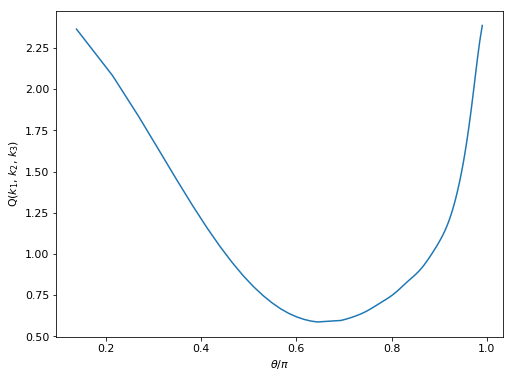

In [16]:
plt.rcParams['figure.figsize'] = (8, 6)

def angle(a,b,c):
    return math.acos(-(a**2. + b**2. -(c**2.))/(2.*a*b))

t_check=np.array(t_check)
Q1=k0[min(range(len(k0)), key=lambda i: abs(k0[i]-0.35))]
Q2=k0[min(range(len(k0)), key=lambda i: abs(k0[i]-0.4))]

ang=[angle(Q1,Q2,i)/np.pi for i in np.array(t_check)[:,2]]
plt.plot(ang, Q_check)
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'Q($k_1$, $k_2$, $k_3$)')
plt.show()

#### Bispectrum for various cosmologies

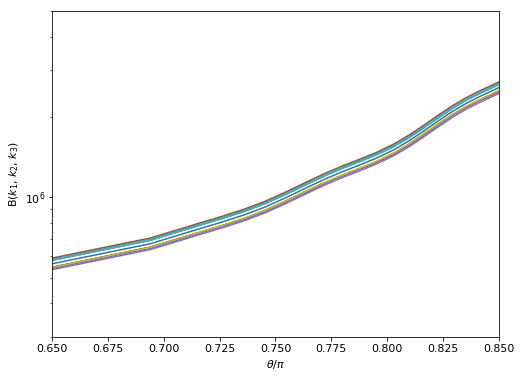

In [17]:
for i in range(len(vary)):
    plt.plot(ang, np.array(Bisp)[:,i])
plt.plot(ang, B_check)
plt.yscale('log')
plt.xlim(0.65, 0.85)
plt.ylim(3*10**5, 5*10**6)
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'B($k_1$, $k_2$, $k_3$)')
plt.show()

## Consistency checks

#### Shape of the reduced bispectrum

To compare with the literature, we calculate the reduced bispectrum, which is defined as

\begin{equation}
Q_{123} = \frac{B_{123}}{P_1 P_2 + P_2 P_3 + P_1 P_3}.
\end{equation}

We consider the particular configurations given by $k_1 = 0.4$ h/Mpc and $k_2 = 0.2$ h/Mpc to compare with Fig. 2 in astro-ph/0312286 or Fig. 9 in astro-ph/0112551.

In [18]:
fid_interp = interp1d(k0, PS_fid0, kind='cubic')

K1=0.41
K2=0.2
K3=np.linspace((K1-K2), K1+K2 , 200)
Q_test=np.zeros((len(K3)))
B_test=np.zeros((len(K3)))
cont=0

for l in range(len(K3)):
    B_test[l]=(2.*F_2(K1, K2, K3[l])*fid_interp(K1)*fid_interp(K2) + 2.*F_2(K2, K3[l], K1)*fid_interp(K2)*fid_interp(K3[l]) 
    + 2.*F_2(K3[l], K1, K2)*fid_interp(K3[l])*fid_interp(K1))
    Q_test[l]=B_test[l]/(fid_interp(K1)*fid_interp(K2) + fid_interp(K2)*fid_interp(K3[l]) + fid_interp(K1)*fid_interp(K3[l]))

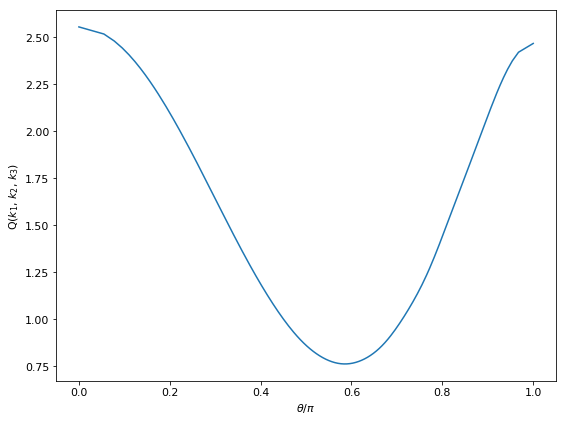

In [19]:
ang2=[angle(K1,K2,i)/np.pi for i in K3]
plt.plot(ang2, Q_test)
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'Q($k_1$, $k_2$, $k_3$)')
plt.tight_layout()
#plt.savefig('reduced.pdf')
plt.show()

#### Step size of the derivative

To check that the numerical derivative is stable with respect to step size, we compute it using smaller and larger step sizes.

In [20]:
step_dict_min={'Omc':[0.002], 'w':[0.02]}
params_list_min,_=list_params(step_dict_min, fid_params)

step_dict_max={'Omc':[0.004], 'w':[0.04]}
params_list_max,_=list_params(step_dict_max, fid_params)

print 'Parameters for the smallest step size:', params_list_min
print 'Parameters for the largest step size:', params_list_max

Parameters for the smallest step size: [[0.266, 0.268, 0.27], [0.048], [0.675], [2e-09], [-1.02, -1.0, -0.98], [0.965]]
Parameters for the largest step size: [[0.264, 0.268, 0.272], [0.048], [0.675], [2e-09], [-1.04, -1.0, -0.96], [0.965]]


In [21]:
_, PS_min, _, vary_min, _, _=calculate_PS(params_list_min, params_f, len(step_dict_min), False, [0.0], 0.8)
t_check, _, _, _, dB_min = BQ(0.35, 0.4, k0, PS_min, PS_fid0, [0.0], vary_min)

_, PS_max, _, vary_max, _, _=calculate_PS(params_list_max, params_f, len(step_dict_max), False, [0.0], 0.8)
t_check, _, _, _, dB_max = BQ(0.35, 0.4, k0, PS_max, PS_fid0, [0.0], vary_max)

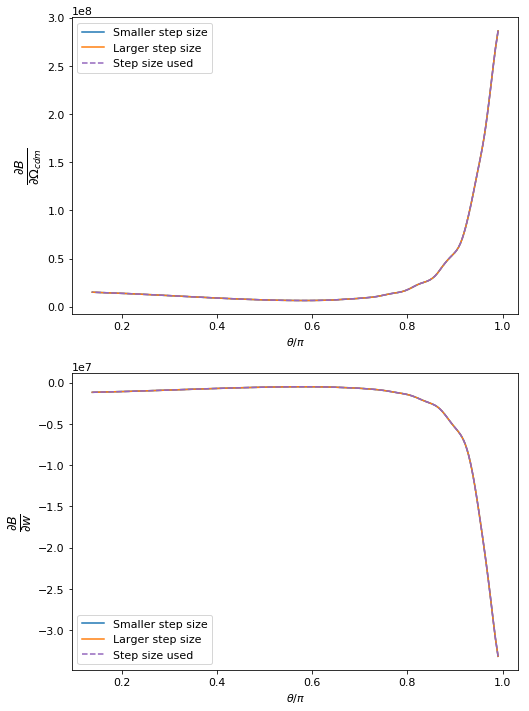

In [22]:
dB_min=np.array(dB_min)
dB=np.array(dB)
dB_max=np.array(dB_max)

plt.rcParams['figure.figsize'] = (8, 12)

plt.subplot(211)
plt.plot(ang, dB_min[:,0,0], 'C0', label='Smaller step size')
plt.plot(ang, dB_max[:,0,0], 'C1', label='Larger step size')
plt.plot(ang, dB[:,0,0],'C4--', label='Step size used')
plt.legend()
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'$\frac{\partial B}{\partial \Omega_{cdm}}$', fontsize=18)

plt.subplot(212)
plt.plot(ang, dB_min[:,1,0], 'C0', label='Smaller step size')
plt.plot(ang, dB_max[:,1,0], 'C1', label='Larger step size')
plt.plot(ang, dB[:,-2,0],'C4--', label='Step size used')
plt.legend()
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'$\frac{\partial B}{\partial w}$', fontsize=18)
plt.show()

#### Variation of n(z)
$$ n_{\text{new}}(z) = \alpha n(z) $$

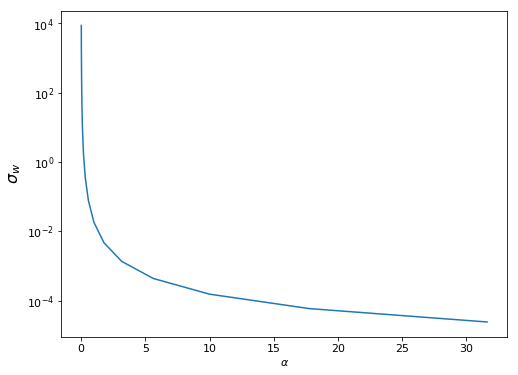

In [23]:
plt.rcParams['figure.figsize'] = (8, 6)

sigma_w = loadtxt("sigw3.txt", comments="#", delimiter=",", unpack=False)

plt.plot(np.logspace(-2, 1.5, 15), sigma_w)
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\sigma_w$', fontsize=16)
plt.show()

## Including $f_{NL}$

The bispectrum due to primordial non-Gaussianity in linear perturbation theory is given by

\begin{equation}
B(k_1, k_2, k_3) = 2f_{NL}\left\{ M^{-1}(k_1) M^{-1}(k_2) M(k_3) P(k_1) P(k_2) + \text{cyc.} \right\},
\end{equation}
where

\begin{equation}
M(k,a) = -\frac{3}{5} \frac{k^2 D(a)\ T(k)}{\Omega_m H^2_0}
\end{equation}

#### Linear growth factor D(a)

\begin{equation}
D(a) = \frac{5 \Omega_m}{2} \frac{H(a)}{H_0} \int_0^a \frac{da'}{(a' H(a')/H_0)^3}
\end{equation}

In [24]:
def E(A, omg_m, omg_de, w):
    return np.sqrt((omg_m/(A**3.) + omg_de/(A**(3.*(1.+w)))))

def growth1(A, omg_m, omg_de, w):
    a2=np.linspace(10**(-7), A, 200)
    e=np.array([E(i, omg_m, omg_de, w) for i in a2])
    return 2.5*omg_m*E(A, omg_m, omg_de, w)*integrate.simps((a2*e)**(-3.), a2)

a1=np.linspace(0.1,1, 200)
D1=np.array([growth1(i, 0.316, 0.684, -1.0) for i in a1])

\begin{equation}
f=\Omega^{0.55}_m=\frac{d \log D}{d\log a}
\end{equation}

In [25]:
def growth2(logA, H, H0, Omg_m):
    f=((Omg_m/((np.exp(logA)**3.)*((H**2.)/(H0**2.))))**0.55)
    return min(np.exp(logA))*np.exp((integrate.simps(f, logA)))

loga=np.linspace(np.log(1./(1.+4000.)), np.log(1), 149)
H_z=np.array([67.5*E(i, 0.316, 0.684, -1.0) for i in np.exp(loga)])

loga2=[]; H2=[]
for i in range(len(loga)):
    if np.exp(loga[i])>=0.1:
        loga2.append(loga[0:(i+1)])
        H2.append(H_z[0:(i+1)])
D2=[growth2(loga2[i], H2[i], 67.5, 0.316) for i in range(len(loga2))]
a2=[max(np.exp(loga2[i])) for i in range(len(loga2))]

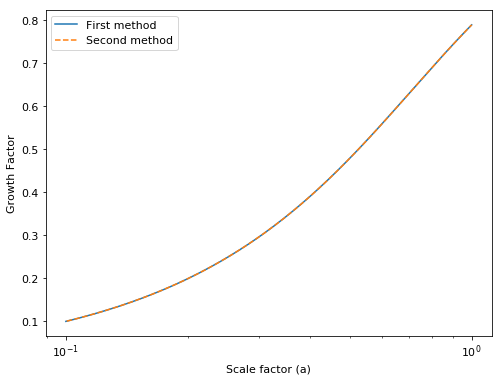

In [26]:
plt.plot(a1, D1, label='First method')
plt.plot(a2, np.array(D2)*(D1[-1]/D2[-1]), '--', label='Second method')
plt.xscale('log')
plt.xlabel('Scale factor (a)')
plt.ylabel('Growth Factor')
plt.legend(loc='best')
plt.show()

#### Transfer function

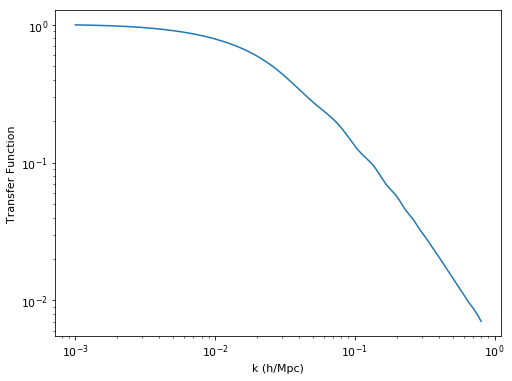

In [27]:
#Normalizing
transf0_norm=transf0[0]/transf0[0,0]

plt.loglog(k0, transf0_norm)
plt.xlabel('k (h/Mpc)')
plt.ylabel('Transfer Function')
plt.show()

In [28]:
#Matter power spectrum from primordial PS

def Delta_r(K, As, ns, K_star):
    return As*((K/K_star)**(ns-1.))

Delta=Delta_r(k0, 2e-9, 0.965, 0.05)*(4./25.)*((((k0)**2.)*D1[-1]*(transf0_norm)/(((100./c)**(2.))*0.316))**2.)
P2=(2.*(np.pi**2.)*Delta)/(k0**3.)

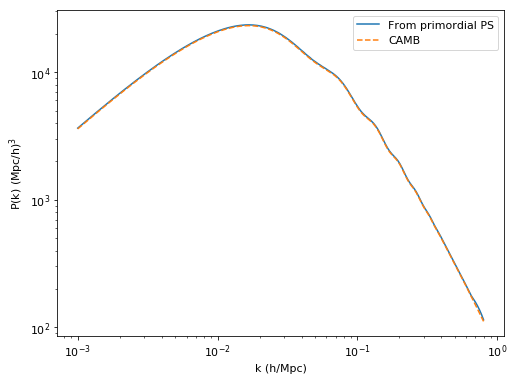

In [29]:
plt.loglog(k0, P2, label='From primordial PS')
plt.loglog(k0, PS_fid0[0],'--', label='CAMB')
plt.ylabel(r'P(k) (Mpc/h)$^3$')
plt.xlabel('k (h/Mpc)')
plt.legend(loc='best')
plt.show()

### Bispectrum due to primordial non-Gaussianity 

The total bispectrum is given by the sum of the linearly evolved bispectrum due to primordial non-Gaussianity ($B^L$) and the bispectrum due to non-linear gravitational evolution ($B^G$) of a initially Gaussian field

\begin{equation}
B_{123} = B^L + B^G .
\end{equation}

To compare once again with Fig. 2 in astro-ph/0312286, we calculate the bispectrum for $k_1 = 0.4$ h/Mpc and $k_2 = 0.2$ h/Mpc with $f_{NL} = \pm 100$.

In [30]:
def M(K, T, D, Omg_m):
    return -(3./5.)*(((K**2.)*T*D)/(Omg_m*((100./c)**2.)))

f_nl=[-100., 100.]
norm_interp=interp1d(k0, transf0_norm)

Q_tot=np.zeros((len(f_nl), len(K3)))
B_prim=np.zeros((len(f_nl), len(K3)))

M1=M(K1, norm_interp(K1), D1[-1], 0.316)
M2=M(K2, norm_interp(K2), D1[-1], 0.316)

for m in range(len(f_nl)):
    for l in range(len(K3)):
        M3=M(K3[l], norm_interp(K3[l]), D1[-1], 0.316)
        
        B_prim[m][l]=2.*f_nl[m]*((1./M1)*(1./M2)*M3*fid_interp(K1)*fid_interp(K2) + (1./M2)*(1./M3)*M1*fid_interp(K2)*fid_interp(K3[l]) 
        + (1./M3)*(1./M1)*M2*fid_interp(K3[l])*fid_interp(K1))
        
        Q_tot[m][l]=(B_prim[m][l] + B_test[l])/(fid_interp(K1)*fid_interp(K2) + fid_interp(K2)*fid_interp(K3[l]) + fid_interp(K1)*fid_interp(K3[l]))

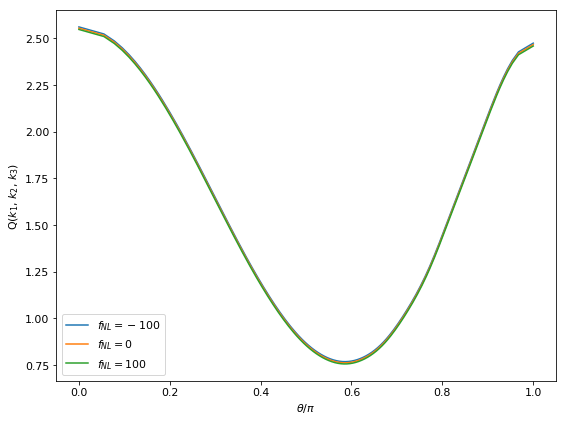

In [31]:
plt.plot(ang2, Q_tot[0], label=r'$f_{NL} = -100$')
plt.plot(ang2, Q_test, label=r'$f_{NL} = 0$')
plt.plot(ang2, Q_tot[1], label=r'$f_{NL} = 100$')
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'Q($k_1$, $k_2$, $k_3$)')
plt.legend(loc='best')
plt.tight_layout()
#plt.xlim(0.55, 0.65)
#plt.ylim(0.7, 0.85)
plt.show()

$$ M^2 = \frac{P(k)}{P_{\Phi}(k)} $$

In [32]:
def M_2(K, As, ns, K_star, P):
    P_phi=((18.*(np.pi**2.))/(25.*K**3.))*Delta_r(K, As, ns, K_star)
    return -np.sqrt(P/P_phi)

f_nl=[-100., 100.]
norm_interp=interp1d(k0, transf0_norm)

Q_tot2=np.zeros((len(f_nl), len(K3)))
B_prim2=np.zeros((len(f_nl), len(K3)))

M1_2=M_2(K1, 2e-9, 0.965, 0.05, fid_interp(K1))
M2_2=M_2(K2, 2e-9, 0.965, 0.05, fid_interp(K2))

for m in range(len(f_nl)):
    for l in range(len(K3)):
        M3_2=M_2(K3[l], 2e-9, 0.965, 0.05, fid_interp(K3[l]))
        
        B_prim2[m][l]=2.*f_nl[m]*((1./M1_2)*(1./M2_2)*M3_2*fid_interp(K1)*fid_interp(K2) 
                                 + (1./M2_2)*(1./M3_2)*M1_2*fid_interp(K2)*fid_interp(K3[l]) 
                                 + (1./M3_2)*(1./M1_2)*M2_2*fid_interp(K3[l])*fid_interp(K1))
        
        Q_tot2[m][l]=(B_prim2[m][l] + B_test[l])/(fid_interp(K1)*fid_interp(K2) + fid_interp(K2)*fid_interp(K3[l]) 
                                                + fid_interp(K1)*fid_interp(K3[l]))

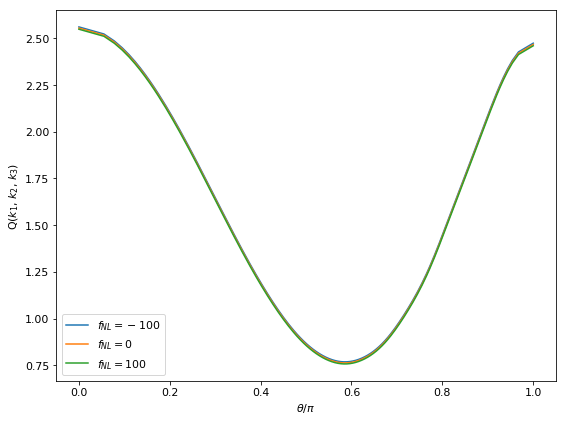

In [33]:
plt.plot(ang2, Q_tot2[0], label=r'$f_{NL} = -100$')
plt.plot(ang2, Q_test, label=r'$f_{NL} = 0$')
plt.plot(ang2, Q_tot2[1], label=r'$f_{NL} = 100$')
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'Q($k_1$, $k_2$, $k_3$)')
plt.legend(loc='best')
plt.tight_layout()
#plt.xlim(0.55, 0.65)
#plt.ylim(0.7, 0.85)
plt.show()

#### Equilateral triangles

In [34]:
K_test=np.linspace(0.002, 0.7, 400)

Q_tot3=np.zeros((len(f_nl), len(K_test)))
B_prim3=np.zeros((len(f_nl), len(K_test)))
for m in range(len(f_nl)):
    for l in range(len(K_test)):
        M_k=M(K_test[l], norm_interp(K_test[l]), D1[-1], 0.316)

        Q_tot3[m][l]=2.*f_nl[m]/(M_k) + 4./7.

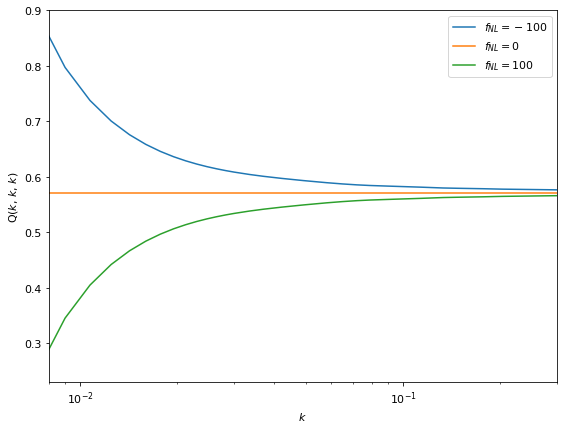

In [35]:
plt.plot(K_test, Q_tot3[0], label=r'$f_{NL} = -100$')
plt.plot(K_test, (4./7.)*np.ones((len(K_test))), label=r'$f_{NL} = 0$')
plt.plot(K_test, Q_tot3[1], label=r'$f_{NL} = 100$')
plt.xlabel(r'$k$')
plt.ylabel(r'Q($k$, $k$, $k$)')
plt.tight_layout()
plt.xlim(0.008, 0.3)
plt.ylim(0.23, 0.9)
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### Fisher matrix including $f_{NL}$

In [36]:
#Growth function and transfer function

D_z=np.zeros((len(vary), len(zspec_tmp)))
D_fid=[growth1(i, 0.316 , (1.-0.316), -1.) for i in (1./(1.+zspec_tmp))]

for i in range(len(vary)):
    for j in range(len(zspec_tmp)):
        a=1./(1.+zspec_tmp[j])
        D_z[i][j]=growth1(a, omg_m[i], (1.-omg_m[i]), w[i])

Transf_norm=np.zeros(Transf.shape)
Tfid_norm=np.array([Transf_fid[i,:]/Transf_fid[i,0] for i in range(len(zspec_tmp))])

for i in range(len(Transf)):
    for j in range(len(Transf[i])):
        Transf_norm[i][j]=Transf[i,j,:]/Transf[i,j,0]

In [100]:
def B_prim(a,b,c, P_a, P_b, P_c, M_a, M_b, M_c, F_nl):
    return 2.*F_nl*((1./M_a)*(1./M_b)*M_c*P_a*P_b + (1./M_b)*(1./M_c)*M_a*P_b*P_c + (1./M_a)*(1./M_c)*M_b*P_a*P_c)

def Fisher_fnl(K, P, P_fid, Rz, F_sky, redshift, Hz, Nz, Vary, Omg_m, F_nl):
    Omg_m2=np.outer(Omg_m, np.ones((len(redshift))))
    
    F=np.zeros((len(Vary)/2 +1, len(Vary)/2 +1))
    for p in range(len(Vary)/2 +1):
        for q in range(len(Vary)/2 +1):
            integrand3=[]
            for i in range(len(K)):
                integrand2=[]
                k2=[]
                for j in range(i,len(K)):
                    k2.append(K[j])
                    integrand1=[]
                    k1=[]
                    for l in range(j,len(K)):
                        k_lim=min((K[i]+K[j]), max(K))
                        if K[l]<=k_lim:
                            k1.append(K[l])
                            B_tot=np.array(B(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l]) 
                                    + B_prim(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l], M(K[i], Transf_norm[:,:,i], D_z[:,:], Omg_m2[:,:]), M(K[j], Transf_norm[:,:,j], D_z[:,:], Omg_m2[:,:]), M(K[l], Transf_norm[:,:,l], D_z[:,:], Omg_m2[:,:]), 0.8))
                            B_tot=np.vstack((B_tot, (B(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l]) 
                                   + B_prim(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[0])).reshape((1, len(redshift)))))
                            B_tot=np.vstack((B_tot, (B(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l])
                                   + B_prim(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316), M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[1])).reshape((1, len(redshift)))))
                            
                            deriv=Derivative(np.concatenate((Vary, F_nl)), B_tot, redshift)
                            integrand_z=(F_sky*((Rz**2.)/Hz)*deriv[p]*deriv[q]*((K[i]*K[j]*K[l])/(2.*(np.pi**3.)*(P_fid[:,i]+(1./Nz))*(P_fid[:,j]+(1./Nz))*(P_fid[:,l]+(1./Nz)))))
                            integrand1.append(integrate.simps(integrand_z, redshift))
                    integrand2.append(integrate.simps(integrand1, k1))
                integrand3.append(integrate.simps(integrand2, k2))
            F[p][q]=integrate.simps(integrand3, K)
    return F

f_nl=[0.8- 0.8*1., 0.8 +0.8*1.]
F_fnl=Fisher_fnl(k, PS, PS_fid, r_z, f_sky, zspec_tmp, H_bar, nspec_tmp, vary, omg_m, f_nl)

In [128]:
step_label.append('f_nl')
Cov2=np.linalg.inv(F_fnl)
M2 = pd.DataFrame(Cov2, index=step_label, columns=step_label)
print M2

               Omc           Omb            As            ns             w  \
Omc   3.906767e-04 -3.011602e-05 -1.617891e-12  6.014229e-04 -1.113186e-03   
Omb  -3.011602e-05  2.161558e-05  4.295674e-13 -1.101251e-05  1.228422e-04   
As   -1.617891e-12  4.295674e-13  1.838375e-20  1.470545e-11  5.020795e-12   
ns    6.014229e-04 -1.101251e-05  1.470545e-11  4.317444e-02 -1.670867e-03   
w    -1.113186e-03  1.228422e-04  5.020795e-12 -1.670867e-03  3.633167e-03   
f_nl -9.385738e-02  8.042906e-03  1.064633e-09  3.847812e-01 -7.837604e-02   

              f_nl  
Omc  -9.385738e-02  
Omb   8.042906e-03  
As    1.064633e-09  
ns    3.847812e-01  
w    -7.837604e-02  
f_nl  1.197222e+03  
